In [1]:
import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)
print(keras.__version__)

2.8.0
2.8.0


In [2]:
# create a data generator
datagen = ImageDataGenerator(rescale=(1/255))

In [3]:
# 图像归为 224 224
import os
import cv2
import glob
import numpy as np

min_side = 224

def mkdir(path):
    if not os.path.exists(path):
        os.mkdir(path)
def process_image(img):
    size = img.shape
    h, w = size[0], size[1]
    #长边缩放为min_side 
    scale = max(w, h) / float(min_side)
    new_w, new_h = int(w/scale), int(h/scale)
    resize_img = cv2.resize(img, (new_w, new_h))
    # 填充至min_side * min_side
    if new_w % 2 != 0 and new_h % 2 == 0:
        top, bottom, left, right = (min_side-new_h)/2, (min_side-new_h)/2, (min_side-new_w)/2 + 1, (min_side-new_w)/2
    elif new_h % 2 != 0 and new_w % 2 == 0:
        top, bottom, left, right = (min_side-new_h)/2 + 1, (min_side-new_h)/2, (min_side-new_w)/2, (min_side-new_w)/2
    elif new_h % 2 == 0 and new_w % 2 == 0:
        top, bottom, left, right = (min_side-new_h)/2, (min_side-new_h)/2, (min_side-new_w)/2, (min_side-new_w)/2
    else:
        top, bottom, left, right = (min_side-new_h)/2 + 1, (min_side-new_h)/2, (min_side-new_w)/2 + 1, (min_side-new_w)/2
    pad_img = cv2.copyMakeBorder(resize_img, int(top), int(bottom), int(left), int(right), cv2.BORDER_CONSTANT, value=[255,255,255]) #从图像边界向上,下,左,右扩的像素数目
    #print pad_img.shape
    #cv2.imwrite("after-" + os.path.basename(filename), pad_img)
    return pad_img

def resize(data_dir):
    save_dir = data_dir + "_pad_" + str(min_side)
    mkdir(save_dir)
    num = 0
    for label in os.listdir(data_dir):
        num += 1
        print("%d/%d, label:%s" %(num, len(os.listdir(data_dir)), label))
        mkdir(os.path.join(save_dir, label))
        for img in glob.glob(os.path.join(data_dir, label, "*.png")):
            #print img
            image = cv2.imread(img)
            if type(image) == type(None):
                print("damaged image %s, del it" %(img))
                os.remove(img)
                continue
            img_pad = process_image(image)
            cv2.imwrite(os.path.join(save_dir, label, os.path.basename(img)), img_pad)

In [4]:
!rm -rf ./content/valid_pad_224/
!rm -rf ./content/components_pad_224/
resize('./content/components')
resize('./content/valid')

1/4, label:.DS_Store
2/4, label:input
3/4, label:button
4/4, label:select
1/4, label:.DS_Store
2/4, label:input
3/4, label:button
4/4, label:select


In [5]:
import pathlib
import re

# 文件目录处理
data_dir = pathlib.Path('./content/components_pad_224')
# 获取名称
CLASS_NAMES = np.array([item.name for item in data_dir.glob('*') if re.search('\.', item.name) == None])
CLASS_NAMES
# CLASS_NAMES = ['select', 'button', 'input']

array(['input', 'button', 'select'], dtype='<U6')

In [6]:
# load and iterate training dataset
# directory: 目标目录的路径。每个类应该包含一个子目录。任何在子目录树下的 PNG, JPG, BMP, PPM 或 TIF 图像，都将被包含在生成器中。更多细节，详见 此脚本。
# target_size: 整数元组 (height, width)，默认：(256, 256)。所有的图像将被调整到的尺寸。
# color_mode: "grayscale", "rbg" 之一。默认："rgb"。图像是否被转换成 1 或 3 个颜色通道。
# classes: 可选的类的子目录列表（例如 ['dogs', 'cats']）。默认：None。如果未提供，类的列表将自动从 directory 下的 子目录名称/结构 中推断出来，其中每个子目录都将被作为不同的类（类名将按字典序映射到标签的索引）。包含从类名到类索引的映射的字典可以通过 class_indices 属性获得。
# class_mode: "categorical", "binary", "sparse", "input" 或 None 之一。默认："categorical"。决定返回的标签数组的类型：
# "categorical" 将是 2D one-hot 编码标签，
# "binary" 将是 1D 二进制标签，"sparse" 将是 1D 整数标签，
train_data = datagen.flow_from_directory('./content/components_pad_224',
                                         target_size=(224,224),
                                        #  color_mode="grayscale",
                                        #  class_mode='binary',
                                        #  batch_size=64,
                                         classes=list(CLASS_NAMES))
train_data

Found 93 images belonging to 3 classes.


In [7]:
valid_data = datagen.flow_from_directory('./content/valid_pad_224',
                                         target_size=(224,224),
                                        #  color_mode="grayscale",
                                        #  class_mode='binary',
                                        #  batch_size=64,
                                         classes=list(CLASS_NAMES))

Found 13 images belonging to 3 classes.


In [8]:
def show_batch(image_batch, label_batch):
  plt.figure(figsize=(50,50))
  for n in range(5):
      ax = plt.subplot(5,5,n+1)
      plt.imshow(image_batch[n].squeeze())
      # plt.title(CLASS_NAMES[int(label_batch[n])])
      plt.axis('off')

(32, 3)

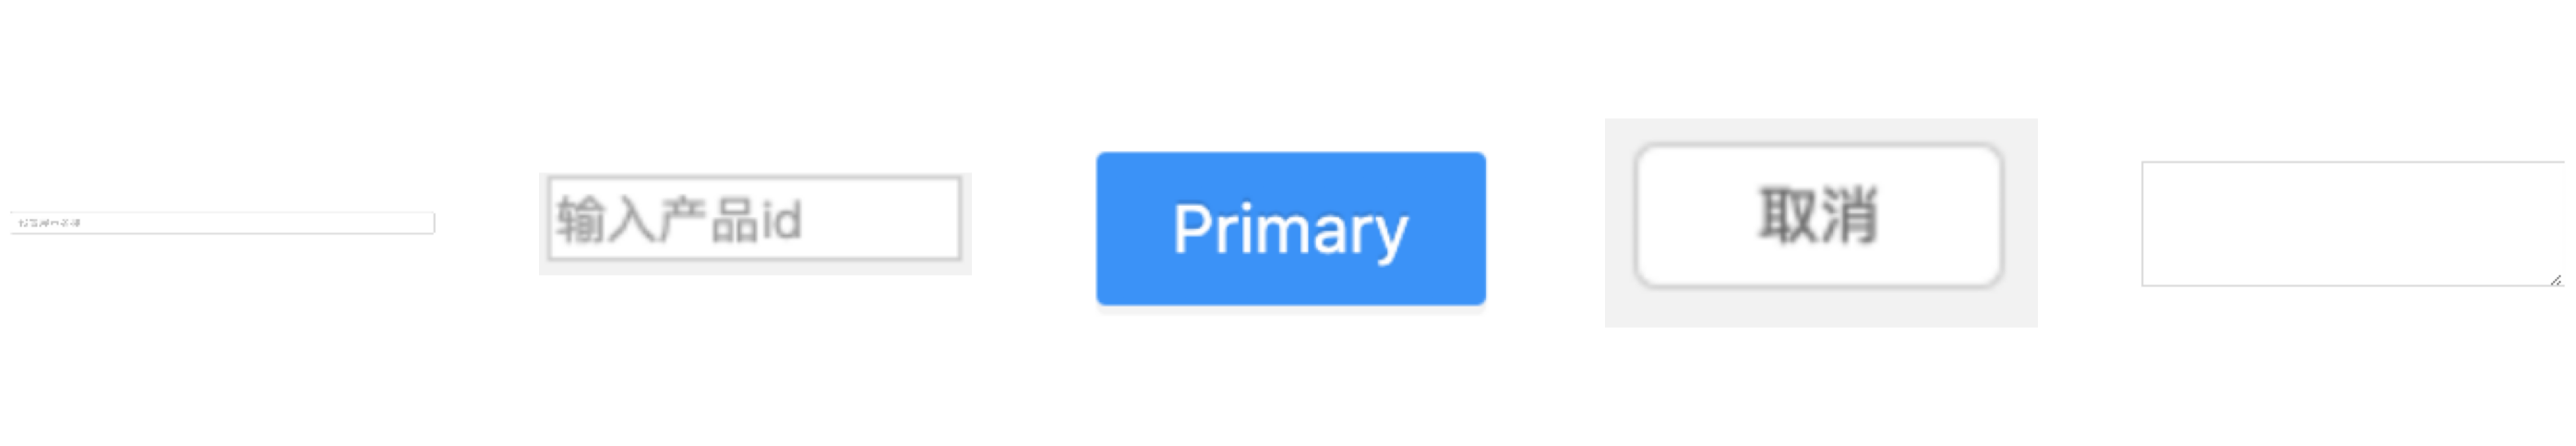

In [9]:
image_batch, label_batch = next(train_data)
show_batch(image_batch, label_batch)
label_batch.shape

In [10]:
# confirm the iterator works
#batchX, batchy = train_data.next()
#x,y = valid_data.next()

In [11]:
# 方法一：全连接的训练
# model = keras.Sequential([
#     keras.layers.Flatten(input_shape=(224, 224)),
#     keras.layers.Dense(1000, activation='relu'),
#     keras.layers.Dense(100, activation='relu'),
#     keras.layers.Dense(6)
# ])
# model.summary()

# # 方法二：自建CNN训练
# model = models.Sequential()
# model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(100, 100, 1)))
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu')) 
# model.add(layers.MaxPooling2D((2, 2)))
# model.add(layers.Conv2D(64, (3, 3), activation='relu'))

# model.add(layers.Flatten())
# model.add(layers.Dense(500, activation='relu'))
# model.add(layers.Dense(3, activation='softmax'))
# model.summary()

# model.compile(optimizer='adam',
#               loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
#               metrics=['accuracy'])
# # fit model
# model.fit(train_data, epochs=10, steps_per_epoch=20, validation_data=valid_data, validation_steps=8)

In [12]:
# 方法三：迁移学习

feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" 

IMAGE_SHAPE = (224, 224)

feature_extractor_layer = hub.KerasLayer(feature_extractor_url, input_shape=(224, 224, 3))



Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-04-04 01:08:33.820121: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-04-04 01:08:33.820220: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [13]:
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)

2022-04-04 01:08:34.206521: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-04-04 01:08:34.207564: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


(32, 1280)


In [14]:
feature_extractor_layer.trainable = False

In [15]:
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(3)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense (Dense)               (None, 3)                 3843      
                                                                 
Total params: 2,261,827
Trainable params: 3,843
Non-trainable params: 2,257,984
_________________________________________________________________


In [16]:
predictions = model(image_batch)

In [17]:
predictions.shape

TensorShape([32, 3])

In [18]:
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

In [19]:
model.fit(train_data, epochs=40, steps_per_epoch=3, validation_data=valid_data, validation_steps=2)


Epoch 1/40


2022-04-04 01:08:37.930227: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - ETA: 0s - loss: 1.2099 - acc: 0.3226

2022-04-04 01:08:39.469598: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


3/3 [==============================] - 3s 694ms/step - loss: 1.2099 - acc: 0.3226 - val_loss: 1.1055 - val_acc: 0.5385
Epoch 2/40
3/3 [==============================] - 1s 283ms/step - loss: 0.9959 - acc: 0.5806
Epoch 3/40
3/3 [==============================] - 1s 282ms/step - loss: 0.8173 - acc: 0.6882
Epoch 4/40
3/3 [==============================] - 1s 319ms/step - loss: 0.6768 - acc: 0.7527
Epoch 5/40
3/3 [==============================] - 1s 321ms/step - loss: 0.5954 - acc: 0.7527
Epoch 6/40
3/3 [==============================] - 1s 289ms/step - loss: 0.5220 - acc: 0.7957
Epoch 7/40
3/3 [==============================] - 1s 287ms/step - loss: 0.4792 - acc: 0.8280
Epoch 8/40
3/3 [==============================] - 1s 280ms/step - loss: 0.4545 - acc: 0.8065
Epoch 9/40
3/3 [==============================] - 1s 285ms/step - loss: 0.4218 - acc: 0.7849
Epoch 10/40
3/3 [==============================] - 1s 278ms/step - loss: 0.3987 - acc: 0.8172
Epoch 11/40
3/3 [==========================

检验

In [20]:
class_names = sorted(train_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names

array(['Input', 'Button', 'Select'], dtype='<U6')

In [21]:
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]

2022-04-04 01:09:15.737753: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


In [22]:
label_id = np.argmax(label_batch, axis=-1)

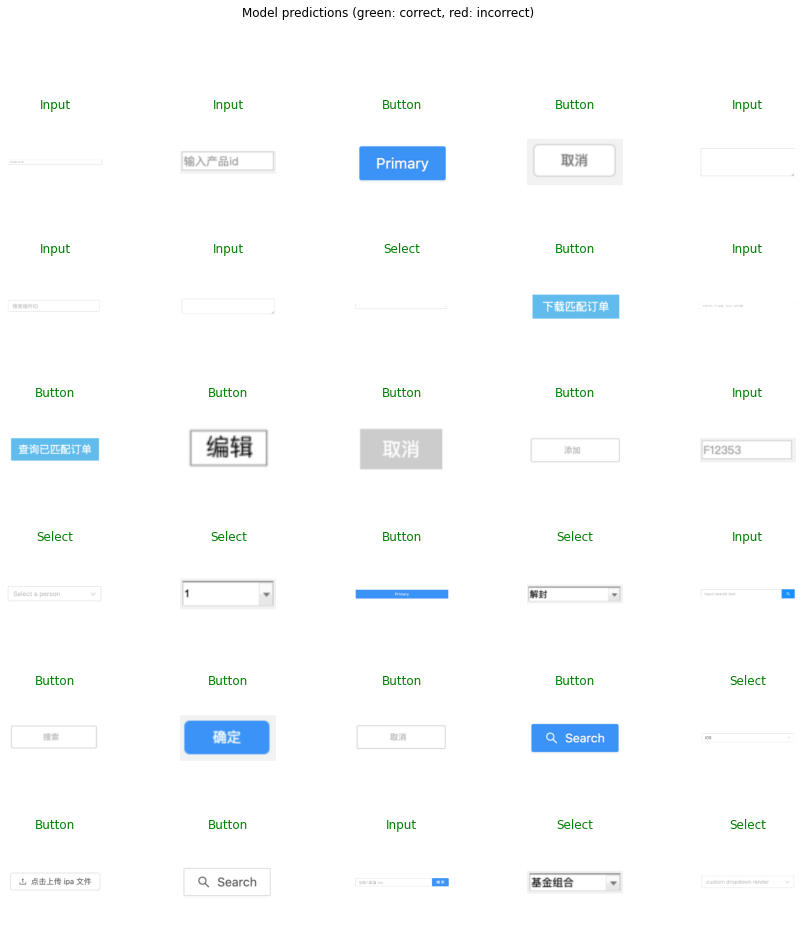

In [23]:
plt.figure(figsize=(15,15))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(predicted_label_batch[n].title(), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")

In [24]:
# 导出模型

import time
t = time.time()

export_path = "./content/model/{}".format(int(t))
model.save(export_path, save_format='tf')

export_path

2022-04-04 01:09:17.398628: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./content/model/1649005756/assets


INFO:tensorflow:Assets written to: ./content/model/1649005756/assets


'./content/model/1649005756'

Now confirm that we can reload it, and it still gives the same results:

In [25]:
reloaded = tf.keras.models.load_model(export_path)

In [26]:
reloaded_result_batch = reloaded.predict(image_batch)
reloaded_result_batch

2022-04-04 01:09:19.969310: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


array([[ 1.4519646 , -4.243505  ,  1.0042987 ],
       [ 1.287882  , -0.76131326,  0.47650546],
       [-3.8572352 ,  3.6503758 , -2.0855227 ],
       [-1.5341231 ,  3.439269  , -0.37964004],
       [ 1.9858584 , -2.6937308 , -0.09496903],
       [ 2.5357556 , -2.4340029 , -0.5000995 ],
       [ 3.1313286 , -4.148616  , -0.63065004],
       [-0.01710244, -5.2063    ,  2.8114474 ],
       [-2.995843  ,  3.0114822 , -1.551261  ],
       [ 1.17875   , -1.884441  , -0.70309407],
       [-2.0653465 ,  2.913267  , -1.4209868 ],
       [-1.884052  ,  3.09413   , -1.3248209 ],
       [-2.7745986 ,  2.151524  , -0.9033544 ],
       [-0.9506824 ,  2.20182   , -0.2936427 ],
       [ 1.503636  , -1.3002716 ,  0.04413812],
       [ 0.33554026, -3.1822486 ,  1.6388354 ],
       [-1.8158072 , -4.3604307 ,  4.0618105 ],
       [ 0.1144744 ,  1.3959157 , -1.0633527 ],
       [-0.06368233, -3.3978863 ,  2.365453  ],
       [ 1.5271441 , -2.115446  , -0.26340193],
       [-1.350133  ,  3.1470637 , -0.394